In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/ayanokojix21/NeuroFormer.git

Cloning into 'NeuroFormer'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 55 (delta 12), reused 47 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 2.36 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
project_path = "/content/NeuroFormer"

In [5]:
import sys
sys.path.append(project_path)

In [6]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import json

In [7]:
from models.NeuroFormer import NeuroFormer # Importing the core Model
from data.utils import Tokenizer

In [8]:
# Setting Device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# For Reproducability
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [10]:
# Loading Tokenizer data
with open(f'{project_path}/tokenizer/char2idx.json') as f:
    char2idx = json.load(f)

In [11]:
tokenizer = Tokenizer(char2idx) # Loading tokenizer object

In [12]:
vocab_size = tokenizer.vocab_size
vocab_size

79

In [13]:
# Model HyperParameters
mode = 'decoder_only'
vocab_size = vocab_size
sequence_length = 512
d_model = 512
num_heads = 8
hidden = 4 * d_model
num_layers = 6
drop_prob = 0.2

In [14]:
# Training HyperParameters
batch_size = 64
total_steps = 2000
lr = 2e-4
best_model_path = 'models/finetune.pt'
os.makedirs('models/', exist_ok = True)

In [15]:
# Data Path
train_path = f'{project_path}/data/finetune/train.txt'
valid_path = f'{project_path}/data/finetune/valid.txt'

with open(train_path, 'r', encoding='utf-8') as f:
    train_data = tokenizer.encode(f.read())

with open(valid_path, 'r', encoding='utf-8') as f:
    valid_data = tokenizer.encode(f.read())

train_data = torch.tensor(train_data, dtype=torch.long)
valid_data = torch.tensor(valid_data, dtype=torch.long)

In [16]:
def get_batch(data, batch_size, block_size):
    idx = torch.randint(len(data) - block_size, (batch_size,))
    X = torch.stack([data[i: i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    return X.to(device), y.to(device)

In [17]:
train_loader = get_batch(train_data, batch_size, sequence_length)
valid_loader = get_batch(valid_data, batch_size, sequence_length)

In [18]:
# Building Up Encoder Only Model
model = NeuroFormer(
    mode=mode,
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    d_model=d_model,
    num_heads=num_heads,
    hidden=hidden,
    num_layers=num_layers,
    drop_prob=drop_prob
).to(device)

In [19]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 25,567,311


In [23]:
checkpoint_path = '/content/drive/MyDrive/Base.pt'
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [24]:
for i, layer in enumerate(model.model.layers):
    if i < 4:
        for param in layer.parameters():
            param.requires_grad = False

In [25]:
# Defining Optimizer, scheduler and Criterion
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-4,
    min_lr=1e-6
)

In [26]:
def eval(model, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:

            input_ids, labels = get_batch(train_data, batch_size, sequence_length)

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [27]:
train_losses, val_losses, val_steps = [], [], []

In [28]:
def train_model():
    model.train()
    best_val_loss = float('inf')
    step = 0

    while step < total_steps:
        for batch in train_loader:

            if step >= total_steps:
                break

            input_ids, labels = get_batch(train_data, batch_size, sequence_length)

            optimizer.zero_grad()

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))

            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            train_losses.append(loss.item())

            if step % 200 == 0 or step == total_steps - 1:
                avg_val_loss = eval(model, valid_loader)
                val_losses.append(avg_val_loss)
                val_steps.append(step)
                model.train()

                print(f"Step {step}: Train Loss: {loss.item():.4f}, Val Loss = {avg_val_loss:.4f}")

                prev_lr = optimizer.param_groups[0]['lr']
                lr_scheduler.step(avg_val_loss)
                new_lr = optimizer.param_groups[0]['lr']
                if new_lr != prev_lr:
                    print(f"Learning rate reduced to {new_lr:.6f}")

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Best model saved at step {step}")

            step += 1

In [29]:
train_model()

Step 0: Train Loss: 1.7726, Val Loss = 1.5924
Best model saved at step 0
Step 200: Train Loss: 1.1123, Val Loss = 1.0482
Best model saved at step 200
Step 400: Train Loss: 1.0570, Val Loss = 1.0300
Best model saved at step 400
Step 600: Train Loss: 1.0555, Val Loss = 0.9992
Best model saved at step 600
Step 800: Train Loss: 1.0549, Val Loss = 0.9921
Best model saved at step 800
Step 1000: Train Loss: 1.0253, Val Loss = 0.9637
Best model saved at step 1000
Step 1200: Train Loss: 1.0205, Val Loss = 0.9480
Best model saved at step 1200
Step 1400: Train Loss: 0.9790, Val Loss = 0.9711
Step 1600: Train Loss: 0.9936, Val Loss = 0.9420
Best model saved at step 1600
Step 1800: Train Loss: 0.9735, Val Loss = 0.9347
Best model saved at step 1800
Step 1999: Train Loss: 0.9962, Val Loss = 0.9270
Best model saved at step 1999


In [30]:
def visualize(train_losses, val_losses, val_steps):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_steps, val_losses, label='Val Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

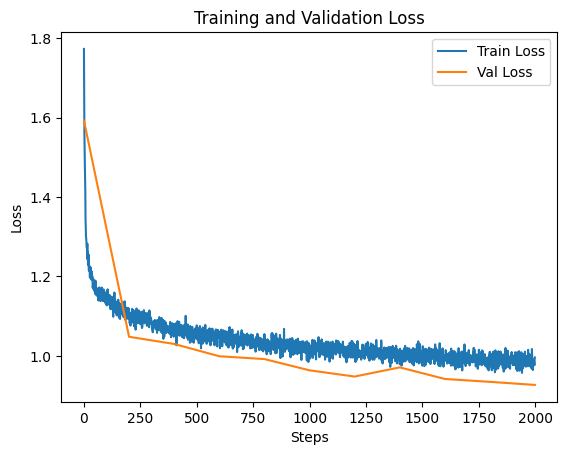

In [31]:
visualize(train_losses, val_losses, val_steps)

In [32]:
import torch
import torch.nn as nn

@torch.no_grad()
def generate(model, tokenizer, start_text, max_new_tokens=200, block_size=256, temperature=1.0, device='cuda'):
    model.eval()

    context_ids = tokenizer.encode(start_text)
    context = torch.tensor(context_ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):

        input_ids = context[:, -block_size:]

        logits = model(input_ids)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)

        context = torch.cat((context, next_token), dim=1)

    output_text = tokenizer.decode(context[0].tolist())
    return output_text

In [33]:
def chat(model, tokenizer, max_new_tokens=200, device='cuda'):
    print("Chatbot ready! Type 'exit' to stop.")
    context = ""

    while True:
        user_input = input("<user> ")
        if user_input.lower() == "exit":
            break

        context += f"<user> {user_input}\n<assistant> "
        response = generate(
            model,
            tokenizer,
            start_text=context,
            max_new_tokens=max_new_tokens,
            block_size=256,
            temperature=0.8,
            device=device
        )

        new_response = response[len(context):].split("<user>")[0].strip()
        print(f"<assistant> {new_response}\n")

        context += f"{new_response}\n"

In [35]:
chat(model, tokenizer, device=device)

Chatbot ready! Type 'exit' to stop.
<user> What is AI
<assistant> Palace ?

<user> Hello How are you
<assistant> In . What are you maintaining ?
<assistant> I was happy .

<user> I am Good
<assistant> Good .

<user> what do you do
<assistant> well , My English in ?
<assistant> I don't know . I'll always be a nice film .

<user> what can you do
<assistant> buy the book did you soon ?

<user> Are you Alright?
<assistant> well , I'm very problems about your English in Linjang . Now much .

<user> Do you Know English
<assistant> what's the problem ?

<user> I have problem in english
<assistant> what do you say ?

<user> How can i improve my english
<assistant> this is the museum ?

<user> what is museum?
<assistant> I don't know what you mean .

<user> exit
